# Yield Model Calculator for D2W hybrid bonding
#### Author: Zhichao Chen
#### Date: Aug 25, 2025
#### Description: YAP+ (pad-layout-aware yield analysis)

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
from utils.util import *
import time
import os
import matplotlib.pyplot as plt
from assembly_yield_calculator import Assembly_Yield_Calculator
from pad_bitmap_generation import pad_bitmap_generate_random

The avg_num_defects_per_unit_area file does not exist, no need to remove.
PAD_ARR_ROW: 10000
PAD_ARR_COL: 10000
Number of pad blocks: 625
Pad block size: 400
Number of critical pad blocks: 625
Number of redundant pad blocks: 0
Number of dummy pad blocks: 0
Pad bitmap collections info saved.
The maximum allowed misalignment is 230.43806696833775 nm.
system_translation_x_samples 0.028635378483431177  nm
system_translation_y_samples -0.01887164590261231  nm
system_rotation_samples 14.122606647896461  nm
system_magnification_samples 0.7071104089841858  nm
far_pad_misalignment_samples 33.202729692526894  nm
Defect yield calculation took 0.20 seconds
Time taken for the sweep: 3.23 seconds
overlay_yield_list:  [0.9999999999998722]
defect_yield_list:  [0.9033542054449608]
Cu_expansion_yield_list:  [0.9951127340643955]
assembly_yield_list:  [0.8989392732087896]


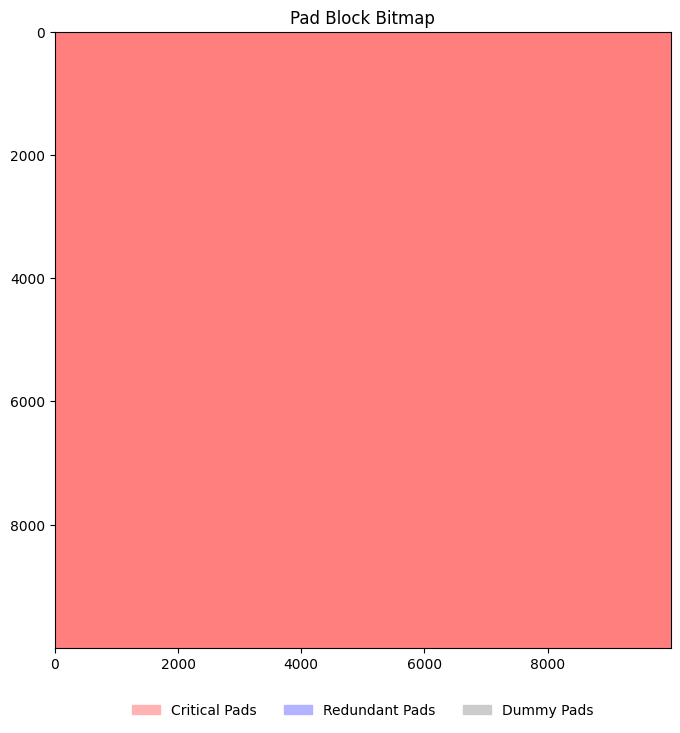

In [6]:
# Load configuration
cfg = load_modeling_config(path='configs/config.yaml', 
                     mode='d2w_modeling',
                     debug=False)

num_points = 1 # Number of points for parameter sweep

# Parameter lists that you want to sweep
die_size_list = np.linspace(10e3, 10e3, num_points)
pitch_list = np.linspace(1, 1, num_points)
particle_density_list = np.linspace(1e-9, 1e-9, num_points) 
# particle_density_list = np.linspace(1e-9, 1e-9, num_points)  # More uniform distribution
t_0_list = np.linspace(0.1, 0.1, num_points)
dish_std_list = np.linspace(1, 1, num_points)
translation_list = np.linspace(0, 0, num_points)
rotation_mean_list = np.linspace(1e-6, 1e-6, num_points)
Roughness_sigma_list = np.linspace(1.0e-9, 1.0e-9, num_points)
PAD_BOT_R_ratio_list = np.linspace(0.5, 0.5, num_points)
PAD_TOP_R_ratio_list = np.linspace(2/3, 2/3, num_points)
bow_difference_mean_list = np.linspace(0.5, 0.5, num_points)
reuse_dilation = False       # You can set this flag to be True to reuse the dilation result
                            # For example, when you are sweeping particle densities, pad layout is not changing,
                            # so you can reuse the dilation result to save computation time


if os.path.exists('pad_bitmap/avg_num_defects_per_unit_area.npy'):
    print("The avg_num_defects_per_unit_area file exists, removing it...")
    os.remove('pad_bitmap/avg_num_defects_per_unit_area.npy')
else:
    print("The avg_num_defects_per_unit_area file does not exist, no need to remove.")


# Now the parameter iteration will not change the bitmap
# So you can put this bitmap generation outside the loop
# cfg.DEBUG = True
assembly_yield_list = []
overlay_yield_list = []
defect_yield_list = []
Cu_expansion_yield_list = []


for i in range(num_points):
    # Update parameters
    cfg.DIE_W = float(die_size_list[i])  # die width (um)
    cfg.DIE_L = float(die_size_list[i])  # die length (um)
    cfg.PITCH = float(pitch_list[i])  # pitch (um)
    cfg.PAD_TOP_R_ratio = float(PAD_TOP_R_ratio_list[i])  # top Cu pad radius ratio
    cfg.PAD_BOT_R_ratio = float(PAD_BOT_R_ratio_list[i])  # bottom Cu pad radius ratio
    cfg.SYSTEM_TRANSLATION_X_MEAN = float(translation_list[i])  # systematic translation mean (um) - x direction
    cfg.SYSTEM_TRANSLATION_Y_MEAN = float(translation_list[i])  # systematic translation mean (um) - y direction
    cfg.SYSTEM_ROTATION_MEAN = float(rotation_mean_list[i])  # systematic rotation mean (rad)
    cfg.D0 = float(particle_density_list[i])  # particle density (um^{-2})
    cfg.t_0 = float(t_0_list[i])  # smallest particle thickness (um)
    cfg.BOW_DIFFERENCE_MEAN = float(bow_difference_mean_list[i])  # bow difference mean (um)
    cfg.TOP_DISH_STD = float(dish_std_list[i])  # Top Cu pad dish standard deviation (nm)
    cfg.BOT_DISH_STD = float(dish_std_list[i])  # Bottom Cu pad dish standard deviation (nm)
    cfg.Roughness_sigma = float(Roughness_sigma_list[i])  # Surface roughness standard deviation (m)
    cfg.redundant_logical_pad_dist = 2.0
    # Update above parameters in the configuration
    update_config_items(cfg=cfg, mode='d2w_modeling')

    if cfg.PITCH >= 1.0:
        if reuse_dilation == False or not os.path.exists('pad_bitmap/avg_num_defects_per_unit_area.npy'):
            pad_bitmap_collection = pad_bitmap_generate_random(cfg=cfg,
                                                               pad_layout_pattern='center')
    else:
        print("Pitch is too small, read existing pad bitmap collection.")
        pad_bitmap_collection = np.load('pad_bitmap/bitmap_collection.npy', allow_pickle=True).item()
        pad_bitmap_collection["pad_block_size"] = cfg.pad_block_size
        pad_bitmap_collection["num_critical_pads"] = cfg.PAD_ARR_ROW * cfg.PAD_ARR_COL * cfg.critical_pad_ratio
        pad_bitmap_collection["num_redundant_logical_pads"] = cfg.PAD_ARR_ROW * cfg.PAD_ARR_COL * cfg.redundant_pad_ratio * cfg.redundant_logical_pad_ratio
        pad_bitmap_collection["redundant_logical_pad_copy"] = cfg.redundant_logical_pad_copy
 

    # Calculate the yield
    start_time = time.time()
    assembly_yield, overlay_yield, defect_yield, Cu_expansion_yield = Assembly_Yield_Calculator(
        cfg=cfg, 
        pad_bitmap_collection=pad_bitmap_collection,
    )
    assembly_yield_list.append(assembly_yield)
    overlay_yield_list.append(overlay_yield)
    defect_yield_list.append(defect_yield)
    Cu_expansion_yield_list.append(Cu_expansion_yield)
    print("Time taken for the sweep: {:.2f} seconds".format(time.time() - start_time))
print("overlay_yield_list: ", overlay_yield_list)
print("defect_yield_list: ", defect_yield_list)
print("Cu_expansion_yield_list: ", Cu_expansion_yield_list)
print("assembly_yield_list: ", assembly_yield_list)

In [21]:
# np.save('correlation/particle_density/calc_df_yield_list_pd_-10_-7d6_size_1e4_300params_400dim.npy', defect_yield_list)

In [ ]:
overlay_yield_list

In [ ]:
particle_density_list = np.linspace(1e-10, 10**(-7.61), 10)  # More uniform distribution
calculate_particle_yield = [0.9972170393305495,
 0.9245140891648561,
 0.8571116089613925,
 0.7946231634825726,
 0.7366904908780589,
 0.6829814486801806,
 0.6331881095482877,
 0.5870249958444719,
 0.5442274429190347,
 0.5045500817220104]
simulate_particle_yield = [0.996, 0.9255, 0.8585, 0.7995, 0.732, 0.686, 0.626, 0.586, 0.5615, 0.504]

calculate_particle_yield = np.array(calculate_particle_yield)
simulate_particle_yield = np.array(simulate_particle_yield)

# plot the calculated yield vs. the simulated yield
plt.figure()
plt.plot(particle_density_list, calculate_particle_yield, label='calculated yield')
plt.plot(particle_density_list, simulate_particle_yield, label='simulated yield')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Assembly Yield')
plt.legend()
plt.show()

# Calculate the correlation between the calculated yield and the simulated yield
np.corrcoef(calculate_particle_yield, simulate_particle_yield)


In [ ]:
# save the data as mat for matlab
from scipy.io import savemat
# savemat("../case_study/various_particle_density_die_size/particle_density_list.mat", {"particle_density_list": particle_density_list})
savemat("../case_study/various_particle_density_die_size/d2w_assembly_yield_list_pd_m10_m9_size_10e3.mat", 
        {"d2w_assembly_yield_list_pd_m10_m9_size_10e3": assembly_yield_list})

# savemat("../case_study/various_die_size/die_size_list.mat", {"die_size_list": die_size_list})
# savemat("../case_study/various_die_size_yield_breakdown/d2w_assembly_yield_list_size_3e3_1e4.mat", 
#         {"d2w_assembly_yield_list_size_3e3_1e4": assembly_yield_list})
# savemat("../case_study/various_die_size_yield_breakdown/d2w_overlay_yield_list_size_3e3_1e4.mat",
#         {"d2w_overlay_yield_list_size_3e3_1e4": overlay_yield_list})
# savemat("../case_study/various_die_size_yield_breakdown/d2w_defect_yield_list_size_3e3_1e4.mat",
#         {"d2w_defect_yield_list_size_3e3_1e4": defect_yield_list})
# savemat("../case_study/various_die_size_yield_breakdown/d2w_Cu_expansion_yield_list_size_3e3_1e4.mat",
#         {"d2w_Cu_expansion_yield_list_size_3e3_1e4": Cu_expansion_yield_list})

# savemat("../case_study/various_pitch/d2w_assembly_yield_list_pitch_1_10_size_3d2e3.mat", 
#         {"d2w_assembly_yield_list_pitch_1_10_size_3d2e3": assembly_yield_list})

# savemat("../case_study/various_pitch_yield_breakdown/d2w_assembly_yield_list_pitch_1_5_size_1e4.mat", 
#         {"d2w_assembly_yield_list_pitch_1_5_size_1e4": assembly_yield_list})
# savemat("../case_study/various_pitch_yield_breakdown/d2w_overlay_yield_list_pitch_1_5_size_1e4.mat",
#         {"d2w_overlay_yield_list_pitch_1_5_size_1e4": overlay_yield_list})
# savemat("../case_study/various_pitch_yield_breakdown/d2w_defect_yield_list_pitch_1_5_size_1e4.mat",
#         {"d2w_defect_yield_list_pitch_1_5_size_1e4": defect_yield_list})
# savemat("../case_study/various_pitch_yield_breakdown/d2w_Cu_expansion_yield_list_pitch_1_5_size_1e4.mat",
#         {"d2w_Cu_expansion_yield_list_pitch_1_5_size_1e4": Cu_expansion_yield_list})

# savemat("../case_study/various_fine_pitch_yield_breakdown/pitch_list.mat", {"pitch_list": pitch_list})
# savemat("../case_study/various_fine_pitch_yield_breakdown/d2w_assembly_yield_list_pitch_0d5_1_size_1e4.mat", 
#         {"d2w_assembly_yield_list_pitch_0d5_1_size_1e4": assembly_yield_list})
# savemat("../case_study/various_fine_pitch_yield_breakdown/d2w_overlay_yield_list_pitch_0d5_1_size_1e4.mat",
#         {"d2w_overlay_yield_list_pitch_0d5_1_size_1e4": overlay_yield_list})
# savemat("../case_study/various_fine_pitch_yield_breakdown/d2w_defect_yield_list_pitch_0d5_1_size_1e4.mat",
#         {"d2w_defect_yield_list_pitch_0d5_1_size_1e4": defect_yield_list})
# savemat("../case_study/various_fine_pitch_yield_breakdown/d2w_Cu_expansion_yield_list_pitch_0d5_1_size_1e4.mat",
#         {"d2w_Cu_expansion_yield_list_pitch_0d5_1_size_1e4": Cu_expansion_yield_list})

# savemat("../case_study/various_top_pad_ratio/pad_top_ratio_list.mat", {"pad_top_ratio_list": PAD_TOP_R_ratio_list})
# savemat("../case_study/various_top_pad_ratio/d2w_overlay_yield_list_pad_top_ratio_0d5_1_bow_12.mat",
#         {"d2w_overlay_yield_list_pad_top_ratio_0d5_1_bow_12": overlay_yield_list})

In [ ]:
# plot the assembly yield vs. bow difference mean
plt.figure()
plt.plot(t_0_list, assembly_yield_list, label="Assembly Yield")
plt.scatter(t_0_list, assembly_yield_list)
plt.xscale("log")
plt.xlabel("Minimum Particle Thickness (um)")
plt.ylabel("Yield")
plt.legend()

In [ ]:
defect_yield_list

In [ ]:
# plot the assembly yield vs. particle density
plt.figure()
plt.plot(particle_density_list, assembly_yield_list, label="Assembly Yield")
plt.plot(particle_density_list, overlay_yield_list, label="Overlay Yield")
plt.plot(particle_density_list, defect_yield_list, label="Defect Yield")
plt.plot(particle_density_list, Cu_expansion_yield_list, label="Cu Expansion Yield")
plt.scatter(particle_density_list, assembly_yield_list, label="Assembly Yield")
plt.xscale("log")
plt.xlabel("particle density (um^-2)")
plt.ylabel("Assembly Yield")
plt.legend()
plt.show()

In [ ]:
# plot the assembly yield vs. bow difference mean
plt.figure()
plt.plot(PAD_TOP_R_ratio_list, assembly_yield_list, label="Assembly Yield")
plt.plot(PAD_TOP_R_ratio_list, overlay_yield_list, label="Overlay Yield")
plt.plot(PAD_TOP_R_ratio_list, defect_yield_list, label="Defect Yield")
plt.plot(PAD_TOP_R_ratio_list, Cu_expansion_yield_list, label="Cu Expansion Yield")
plt.xlabel("Top Pad Radius Ratio")
plt.ylabel("Yield")
plt.legend()

In [ ]:
Cu_pattern_density_list = PAD_BOT_R_ratio_list**2 * np.pi
plt.figure()
plt.plot(Cu_pattern_density_list, assembly_yield_list, label="Assembly Yield")
plt.plot(Cu_pattern_density_list, overlay_yield_list, label="Overlay Yield")
plt.plot(Cu_pattern_density_list, defect_yield_list, label="Defect Yield")
plt.plot(Cu_pattern_density_list, Cu_expansion_yield_list, label="Cu Expansion Yield")
plt.scatter(Cu_pattern_density_list, assembly_yield_list, label="Assembly Yield")
plt.xlabel("Cu Density")
plt.ylabel("Assembly Yield")
# plt.xscale("log")
plt.legend()
plt.show()

In [ ]:
# plot the assembly yield vs. particle density
plt.figure()
plt.plot(die_size_list**2/1e6, assembly_yield_list, label="Assembly Yield")
plt.plot(die_size_list**2/1e6, overlay_yield_list, label="Overlay Yield")
plt.plot(die_size_list**2/1e6, defect_yield_list, label="Defect Yield")
plt.plot(die_size_list**2/1e6, Cu_expansion_yield_list, label="Cu Expansion Yield")
plt.scatter(die_size_list**2/1e6, assembly_yield_list, label="Assembly Yield")
plt.xlabel("die area (mm^2)")
plt.ylabel("Assembly Yield")
# plt.xscale("log")
plt.legend()
plt.show()

In [ ]:
# explore the impact of rotation mean on the assembly yield
rotation_mean_list = np.linspace(1.3959e-4, 1.3969e-4, 100)
assembly_yield_list = []
overlay_yield_list = []
defect_yield_list = []
Cu_expansion_yield_list = []
roughness_yield_list = []
for rotation_mean in rotation_mean_list:
    assembly_yield, overlay_yield, defect_yield, Cu_expansion_yield = Assembly_Yield_Calculator(
        NUM_DIES_ON_WAF=NUM_DIES_ON_WAF,
        WAF_R=WAF_R,
        PITCH=PITCH,
        DIE_W=DIE_W,
        DIE_L=DIE_L,
        PAD_TOP_R=PAD_TOP_R,
        PAD_BOT_R=PAD_BOT_R,
        PAD_ARR_ROW=PAD_ARR_ROW,
        PAD_ARR_COL=PAD_ARR_COL,
        VOID_SHAPE='square',
        dice_width=1e+4,
        RANDOM_MISALIGNMENT_MEAN=0,
        RANDOM_MISALIGNMENT_STD=1e-10,
        SYSTEM_TRANSLATION_X_MEAN=0,
        SYSTEM_TRANSLATION_X_STD=1e-10,
        SYSTEM_TRANSLATION_Y_MEAN=0,
        SYSTEM_TRANSLATION_Y_STD=1e-10,
        SYSTEM_ROTATION_MEAN=rotation_mean,
        SYSTEM_ROTATION_STD=1e-10,
        BOW_DIFFERENCE_MEAN=30,
        BOW_DIFFERENCE_STD=1e-10,
        k_mag=k_mag,
        M_0=M_0,
        D0=particle_density,
        z=z,
        t_0=t_0,
        k_r=k_r,
        k_r0=k_r0,
        k_L=k_L,
        k_n=k_n,
        k_S=k_S,
        TOP_DISH_MEAN=TOP_DISH_MEAN,
        TOP_DISH_STD=TOP_DISH_STD,
        BOT_DISH_MEAN=BOT_DISH_MEAN,
        BOT_DISH_STD=BOT_DISH_STD,
        k_et=k_et,
        k_eb=k_eb,
        T_R=T_R,
        T_anl=T_anl,
        Asperity_R=Asperity_R,
        Roughness_sigma=Roughness_sigma,
        eta_s=eta_s,
        Roughness_constant=Roughness_constant,
        Adhesion_energy=Adhesion_energy,
        Young_modulus=Young_modulus,
        Dielectric_thickness=Dielectric_thickness,
        DISH_0=DISH_0,
        k_peel=k_peel
    )
    assembly_yield_list.append(assembly_yield)
    overlay_yield_list.append(overlay_yield)
    defect_yield_list.append(defect_yield)
    Cu_expansion_yield_list.append(Cu_expansion_yield)

In [ ]:
np.sum(overlay_yield_list)

In [ ]:
particle_density_list = np.logspace(-10, -8, 10)
calculate_particle_yield = [0.9897747477163137,
 0.9830015788360227,
 0.9718062384399119,
 0.9534143010223441,
 0.9235060166151692,
 0.8756891958301543,
 0.8013716783782586,
 0.6911708708825158,
 0.5400231329635364,
 0.35779718614655415]

simulate_particle_yield = [0.9884, 0.98, 0.9695, 0.9518, 0.9179, 0.8646, 0.7831, 0.6657, 0.5058, 0.33]

calculate_particle_yield = np.array(calculate_particle_yield)
simulate_particle_yield = np.array(simulate_particle_yield)

# plot the calculated yield vs. the simulated yield
plt.figure()
plt.plot(particle_density_list, calculate_particle_yield, label='calculated yield')
plt.plot(particle_density_list, simulate_particle_yield, label='simulated yield')
plt.xscale('log')
plt.xlabel('Particle Density (um^-2)')
plt.ylabel('Assembly Yield')
plt.legend()
plt.show()

# Calculate the correlation between the calculated yield and the simulated yield
np.corrcoef(calculate_particle_yield, simulate_particle_yield)
